In [74]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import time
import pandas as pd

np.random.seed(42)

# Black-Scholes选择期权 St取某一个值的时候
def black_scholes_call(S, K, r, sigma, T):
    return (S * norm.cdf(d1(S, K, r, sigma, T)) - K * np.exp(-r * T) * norm.cdf(d2(S, K, r, sigma, T)))

def black_scholes_put(S, K, r, sigma, T):
    return (K * np.exp(-r * T) * norm.cdf(d2(S, K, r, sigma, T)) - S * norm.cdf(d1(S, K, r, sigma, T)))

def d1(S, K, r, sigma, T):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

def d2(S, K, r, sigma, T):
    return d1(S, K, r, sigma, T) - sigma * np.sqrt(T)

# 选择期权的定价逻辑
def chooser_option(S, K, r, sigma, U, T):
    call_value = black_scholes_call(S, K, r, sigma, T - U)
    put_value = black_scholes_put(S, K, r, sigma, T - U)
    return max(call_value, put_value)

S0 = 10      # 初始价格
K = 10       # 执行价格
r = 0.1      # 无风险利率
sigma = 0.2   # 股票波动率        
U = 0.5       # 选择时间（年）     
T = 1         # 到期时间（年）    
M = 50000    # 模拟次数
N = 1000       # 时间步数

# 蒙特卡洛模拟选择期权价值 （BS的最终答案）
def monte_carlo_chooser_option(S0, K, r, sigma, U, T, N, M):
    option_values = np.zeros(M)
    for i in range(M):
        SU = S0* np.exp((r - 0.5 * sigma ** 2) * U + sigma * np.sqrt(U) * np.random.normal())
        option_values[i] = chooser_option(SU, K, r, sigma, U, T)
    return np.mean(option_values)* np.exp(-r * U)

chooser_option_price = monte_carlo_chooser_option(S0, K, r, sigma, U, T, N, M)

print(f"The estimated chooser option price at S0 is: {chooser_option_price:.2f}")

The estimated chooser option price at S0 is: 1.33


In [24]:
def binomial_chooser_option(S0, K, r, sigma, U, T, N):
# 二叉树选择期权
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u 
    p = (np.exp(r * dt) - d) / (u - d)


# 初始化并构建资产价格树
    asset_prices = np.zeros((N + 1  , N + 1))
    asset_prices[0, 0] = S0

    for i in range(1, N + 1):
        for j in range(i + 1):
            asset_prices[j, i] = S0 * (u ** (i - j)) * (d ** j)

# 初始化并构建期权价格树
    option_prices_call = np.zeros((N + 1, N + 1))
    option_prices_put = np.zeros((N + 1, N + 1))

    for row in range(N+1):
        option_prices_call[row, N] = max(0, asset_prices[row, N] - K)
        option_prices_put[row, N] = max(0, K - asset_prices[row, N])
        
    for i in range(N - 1, round(U / dt) - 1, -1):
        for j in range(i+1):
            option_prices_call[j, i] =  np.exp(- r * dt) *(p * option_prices_call[j, i + 1] + (1 - p) * option_prices_call[j + 1, i + 1])
            option_prices_put[j, i] =  np.exp(- r * dt) *(p * option_prices_put[j, i + 1] + (1 - p) * option_prices_put[j + 1, i + 1])
        
# U时间的单独判断
    U_index = round(U / dt)
    option_prices_chooser = np.zeros((N + 1, U_index + 1))

    for j in range(U_index + 1):
        option_prices_chooser[j, U_index] = max(option_prices_call[j, U_index], option_prices_put[j, U_index])

# 继续迭代
    for i in range(U_index - 1, -1, -1):
        for j in range(i + 1):
            option_prices_chooser[j, i] =  np.exp(- r * dt) *(p * option_prices_chooser[j, i + 1] + (1 - p) * option_prices_chooser[j + 1, i + 1])

    return option_prices_chooser[0, 0]
print(f"The chooser option price at S0 is: {binomial_chooser_option(S0, K, r, sigma, U, T, N):.2f}")

The chooser option price at S0 is: 1.52


N=1: Monte Carlo Price=1.32, Binomial Tree Price=1.43
N=2: Monte Carlo Price=1.32, Binomial Tree Price=1.51
N=3: Monte Carlo Price=1.32, Binomial Tree Price=1.60
N=4: Monte Carlo Price=1.32, Binomial Tree Price=1.48
N=5: Monte Carlo Price=1.32, Binomial Tree Price=1.52
N=6: Monte Carlo Price=1.32, Binomial Tree Price=1.50
N=7: Monte Carlo Price=1.32, Binomial Tree Price=1.57
N=8: Monte Carlo Price=1.32, Binomial Tree Price=1.51
N=9: Monte Carlo Price=1.32, Binomial Tree Price=1.53
N=10: Monte Carlo Price=1.32, Binomial Tree Price=1.49
N=11: Monte Carlo Price=1.32, Binomial Tree Price=1.56
N=12: Monte Carlo Price=1.32, Binomial Tree Price=1.51
N=13: Monte Carlo Price=1.32, Binomial Tree Price=1.52
N=14: Monte Carlo Price=1.32, Binomial Tree Price=1.49
N=15: Monte Carlo Price=1.32, Binomial Tree Price=1.55
N=16: Monte Carlo Price=1.32, Binomial Tree Price=1.52
N=17: Monte Carlo Price=1.32, Binomial Tree Price=1.52
N=18: Monte Carlo Price=1.32, Binomial Tree Price=1.50
N=19: Monte Carlo P

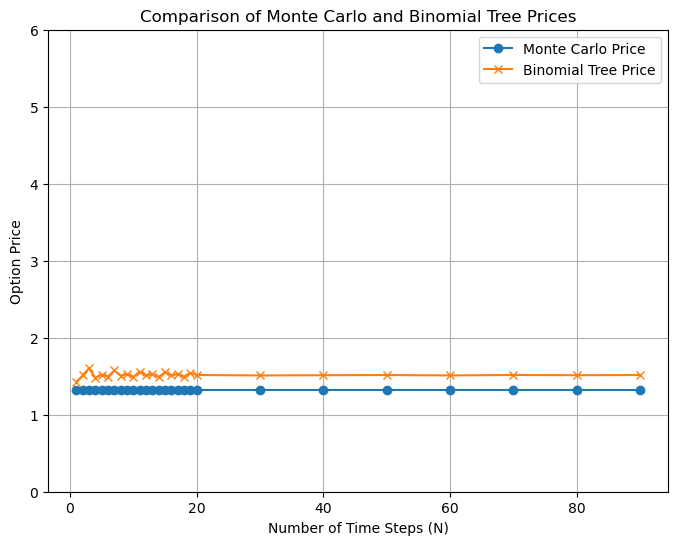

In [39]:
N_values_small = np.arange(1, 20, 1)
N_values_large = np.arange(20, 100, 10)
N_values = np.concatenate((N_values_small, N_values_large))
mc_prices = []
bt_prices = []

mc_price = monte_carlo_chooser_option(S0, K, r, sigma, U, T, N, M)
for N in N_values:
    mc_price = mc_price 
    bt_price = binomial_chooser_option(S0, K, r, sigma, U, T, N)
    mc_prices.append(mc_price)
    bt_prices.append(bt_price)
    print(f"N={N}: Monte Carlo Price={mc_price:.2f}, Binomial Tree Price={bt_price:.2f}")


# 绘制结果
plt.figure(figsize=(8, 6))
plt.plot(N_values, mc_prices, label='Monte Carlo Price', marker='o')
plt.plot(N_values, bt_prices, label='Binomial Tree Price', marker='x')
plt.ylim(0, 6)
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Option Price')
plt.title('Comparison of Monte Carlo and Binomial Tree Prices')
plt.legend()
plt.grid(True)
plt.show()

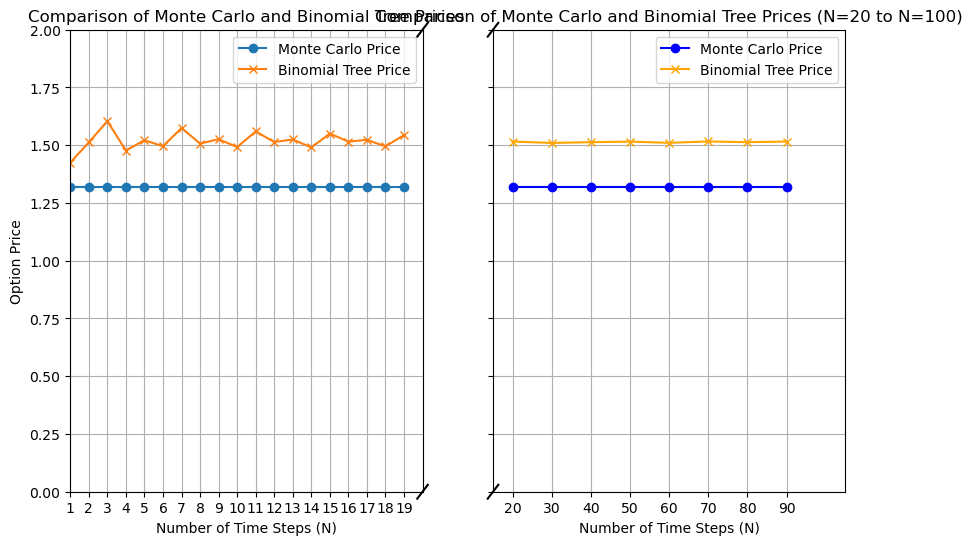

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 6))

# 第一个子图：N=1到N=9
ax1.plot(N_values_small, mc_prices[:len(N_values_small)], label='Monte Carlo Price', marker='o')
ax1.plot(N_values_small, bt_prices[:len(N_values_small)], label='Binomial Tree Price', marker='x')
ax1.set_xticks(np.arange(1, 20, 1))
ax1.set_xlim(1, 20)
ax1.set_ylim(0, 2)
ax1.set_xlabel('Number of Time Steps (N)')
ax1.set_ylabel('Option Price')
ax1.set_title('Comparison of Monte Carlo and Binomial Tree Prices')
ax1.legend()
ax1.grid(True)

# 第二个子图：N=100
ax2.plot(N_values_large, mc_prices[len(N_values_small):], label='Monte Carlo Price', marker='o', color='blue')
ax2.plot(N_values_large, bt_prices[len(N_values_small):], label='Binomial Tree Price', marker='x', color='orange')
ax2.set_xticks(np.arange(20, 100, 10))
ax2.set_xlim(15, 105)
ax1.set_ylim(0, 2)
ax2.set_xlabel('Number of Time Steps (N)')
ax2.set_title('Comparison of Monte Carlo and Binomial Tree Prices (N=20 to N=100)')
ax2.legend()
ax2.grid(True)

# 在两个子图之间添加断点标志
d = .015  # 设置断点的大小
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

plt.show()

比较蒙特卡洛和二叉树计算的时间（先改m）

In [69]:
M_values = np.arange(1000, 5001, 500)
N = 100

mc_times = []
bt_times = []

In [70]:
for M in M_values:
    start_time = time.time()
    monte_carlo_chooser_option(S0, K, r, sigma, U, T, N, M)
    mc_time = time.time() - start_time
    mc_times.append(mc_time)

start_time = time.time()
binomial_chooser_option(S0, K, r, sigma, U, T, N)
bt_time = time.time() - start_time
bt_times.append(bt_time)
print("Monte Carlo Times:", mc_times)
print("Binomial Tree Time:", bt_time)

Monte Carlo Times: [0.45804452896118164, 0.7646057605743408, 0.9607055187225342, 1.2224934101104736, 1.4632675647735596, 1.5292026996612549, 1.699765682220459, 2.0889477729797363, 2.4117026329040527]
Binomial Tree Time: 0.028879642486572266


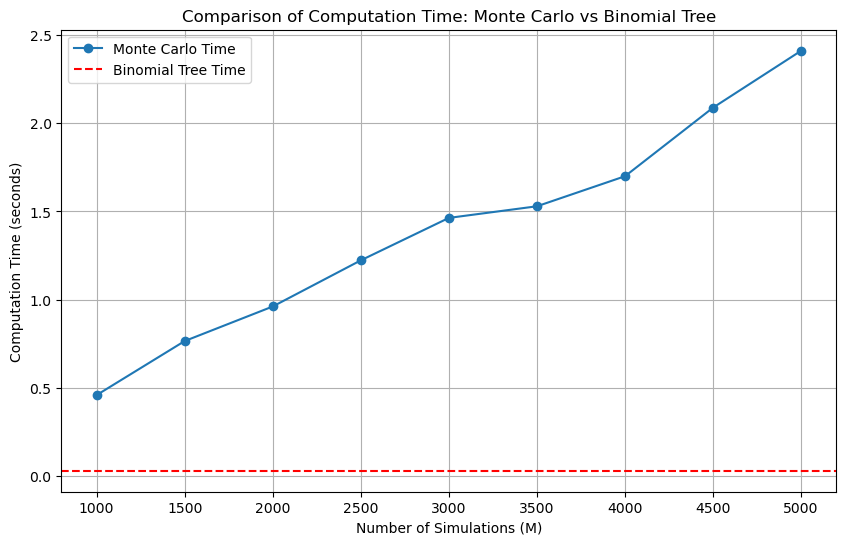

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(M_values, mc_times, label='Monte Carlo Time', marker='o')
plt.axhline(y=bt_time, color='r', linestyle='--', label='Binomial Tree Time')
plt.xlabel('Number of Simulations (M)')
plt.ylabel('Computation Time (seconds)')
plt.title('Comparison of Computation Time: Monte Carlo vs Binomial Tree')
plt.legend()
plt.grid(True)
plt.show()

[1.3610231230018832, 1.3189249027445522, 1.335225440466598, 1.343773883353245, 1.3201222436310376, 1.3277490836238133, 1.3439232861598485, 1.334589069144617, 1.3365915208226455, 1.370901824009945, 1.3074216025809497, 1.2738463371509774, 1.3032631627090097, 1.2992348947241816, 1.362440925275815, 1.3447210359595356, 1.3305508084220137, 1.3248314141222126, 1.3082179188711835, 1.3195379889298262]
[1.33513427551555, 1.3018686035895772, 1.279201453428502, 1.3481923531526494, 1.3147645281533236, 1.350668847687389, 1.3010967475241928, 1.328527277008345, 1.3284072381445924, 1.3133958784448905, 1.3314079312614246, 1.323597567164982, 1.3096527842398804, 1.3516321039380512, 1.3462578683993625, 1.35775413164998, 1.3300535828081526, 1.3400153131883594, 1.3105528521533962, 1.3562743903417571]
[1.3332580111130496, 1.3340277191940901, 1.3211829799816108, 1.3485337476877366, 1.3222862678281555, 1.330911766517872, 1.330053395918069, 1.3132180650106196, 1.2883597621571838, 1.325383456447401, 1.30188152457

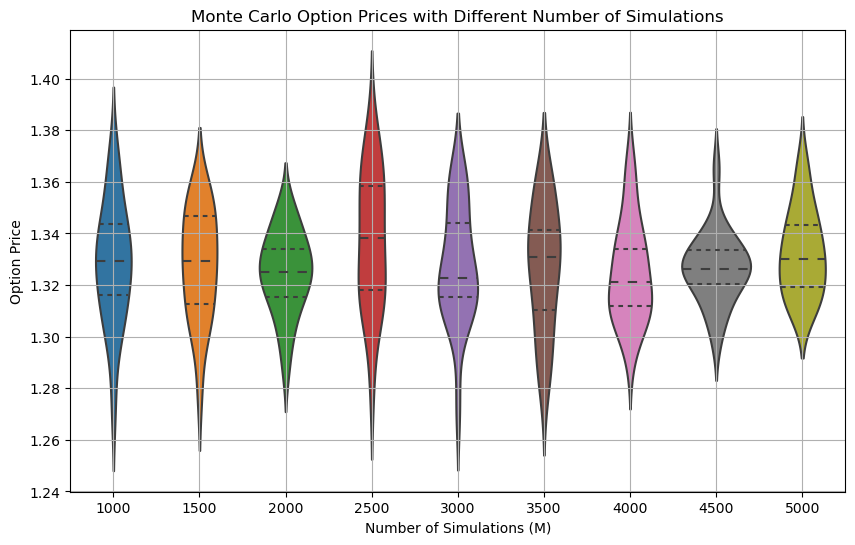

In [96]:
M_values = np.arange(1000, 5001, 500)
mc_prices = []

for M in M_values:
    prices = []
    for _ in range(20):  
        price = monte_carlo_chooser_option(S0, K, r, sigma, U, T, N, M)
        prices.append(price)
    mc_prices.append(prices)
    print(prices)
    
data = []
for i, M in enumerate(M_values):
    for price in mc_prices[i]:
        data.append([M, price])

df = pd.DataFrame(data, columns=['M', 'Price'])

plt.figure(figsize=(10, 6))
sns.violinplot(x='M', y='Price', data=df, inner='quartile')
plt.xlabel('Number of Simulations (M)')
plt.ylabel('Option Price')
plt.title('Monte Carlo Option Prices with Different Number of Simulations')
plt.grid(True)
plt.show()